# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [23]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
import time
num_runs = 200
num_iters = 1500
verbose = False
log_lr = [-7.3, -7.1]
log_rs = [5.7, 6.0]


for run in range(num_runs):
    loglr = np.random.uniform(log_lr[0], log_lr[1])
    logrs =  np.random.uniform(log_rs[0], log_rs[1])
    lr = np.power(10, loglr)
    rs = np.power(10, logrs)
    print('Run %d/%d: evaluating lr=%.6f, rs=%.6f' % (run, num_runs, loglr, logrs))
    tic = time.time()
     
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                          num_iters=num_iters, verbose=verbose)
    training_accuracy =  np.mean(y_train == svm.predict(X_train_feats))
    validation_accuracy =  np.mean(y_val == svm.predict(X_val_feats))
    
    results[(lr, rs)] = (training_accuracy, validation_accuracy)
    toc = time.time()
    print('\ttook %fs' % (toc - tic))
    print('\ttraining accuracy=%.6f' % (training_accuracy))
    print('\tvalidation accuracy=%.6f' % (validation_accuracy))
    
    if validation_accuracy > best_val:
        print('\tBest model!')
        best_val = validation_accuracy
        best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Run 0/200: evaluating lr=-7.108757, rs=5.928972
	took 0.481870s
	training accuracy=0.406367
	validation accuracy=0.419000
	Best model!
Run 1/200: evaluating lr=-7.263870, rs=5.907496
	took 0.496209s
	training accuracy=0.395020
	validation accuracy=0.384000
Run 2/200: evaluating lr=-7.247206, rs=5.664820
	took 0.498641s
	training accuracy=0.404796
	validation accuracy=0.399000
Run 3/200: evaluating lr=-7.266856, rs=5.869826
	took 0.475420s
	training accuracy=0.412959
	validation accuracy=0.416000
Run 4/200: evaluating lr=-7.202930, rs=5.979321
	took 0.473459s
	training accuracy=0.406776
	validation accuracy=0.417000
Run 5/200: evaluating lr=-7.280150, rs=5.878805
	took 0.461915s
	training accuracy=0.416673
	validation accuracy=0.419000
Run 6/200: evaluating lr=-7.239903, rs=5.735683
	took 0.463210s
	training accuracy=0.401735
	validation accuracy=0.390000
Run 7/200: evaluating lr=-7.282786, rs=5.615263
	took 0.465042s
	training accuracy=0.408816
	validation accuracy=0.405000
Run 8/200: 

	took 0.471901s
	training accuracy=0.406980
	validation accuracy=0.410000
Run 67/200: evaluating lr=-7.258968, rs=5.863781
	took 0.471272s
	training accuracy=0.407265
	validation accuracy=0.400000
Run 68/200: evaluating lr=-7.280256, rs=5.602543
	took 0.473427s
	training accuracy=0.414082
	validation accuracy=0.414000
Run 69/200: evaluating lr=-7.106888, rs=5.927123
	took 0.475732s
	training accuracy=0.398857
	validation accuracy=0.410000
Run 70/200: evaluating lr=-7.167980, rs=5.709085
	took 0.468126s
	training accuracy=0.394714
	validation accuracy=0.387000
Run 71/200: evaluating lr=-7.210924, rs=5.717828
	took 0.475985s
	training accuracy=0.410939
	validation accuracy=0.401000
Run 72/200: evaluating lr=-7.155791, rs=5.685974
	took 0.473754s
	training accuracy=0.404061
	validation accuracy=0.409000
Run 73/200: evaluating lr=-7.210220, rs=5.913514
	took 0.473624s
	training accuracy=0.414082
	validation accuracy=0.415000
Run 74/200: evaluating lr=-7.285307, rs=5.674822
	took 0.479504s


	took 0.470448s
	training accuracy=0.410571
	validation accuracy=0.417000
Run 134/200: evaluating lr=-7.234900, rs=5.962250
	took 0.471972s
	training accuracy=0.401367
	validation accuracy=0.398000
Run 135/200: evaluating lr=-7.257278, rs=5.793062
	took 0.482689s
	training accuracy=0.408878
	validation accuracy=0.415000
Run 136/200: evaluating lr=-7.261585, rs=5.998283
	took 0.521123s
	training accuracy=0.408245
	validation accuracy=0.406000
Run 137/200: evaluating lr=-7.193761, rs=5.836373
	took 0.472543s
	training accuracy=0.410286
	validation accuracy=0.394000
Run 138/200: evaluating lr=-7.164278, rs=5.710591
	took 0.480339s
	training accuracy=0.409082
	validation accuracy=0.416000
Run 139/200: evaluating lr=-7.269068, rs=5.894719
	took 0.494233s
	training accuracy=0.403735
	validation accuracy=0.407000
Run 140/200: evaluating lr=-7.274735, rs=5.922627
	took 0.473866s
	training accuracy=0.400776
	validation accuracy=0.395000
Run 141/200: evaluating lr=-7.226363, rs=5.601462
	took 0.

	took 0.462657s
	training accuracy=0.405939
	validation accuracy=0.403000
lr 5.019973e-08 reg 8.813443e+05 train accuracy: 0.404163 val accuracy: 0.408000
lr 5.033324e-08 reg 5.736204e+05 train accuracy: 0.413776 val accuracy: 0.415000
lr 5.039068e-08 reg 5.765764e+05 train accuracy: 0.411571 val accuracy: 0.413000
lr 5.041181e-08 reg 5.549430e+05 train accuracy: 0.411204 val accuracy: 0.404000
lr 5.057196e-08 reg 4.780140e+05 train accuracy: 0.409327 val accuracy: 0.413000
lr 5.073720e-08 reg 6.945434e+05 train accuracy: 0.409306 val accuracy: 0.406000
lr 5.112931e-08 reg 5.790320e+05 train accuracy: 0.409306 val accuracy: 0.429000
lr 5.118029e-08 reg 7.729400e+05 train accuracy: 0.399837 val accuracy: 0.389000
lr 5.123752e-08 reg 5.205055e+05 train accuracy: 0.404429 val accuracy: 0.392000
lr 5.127127e-08 reg 4.053198e+05 train accuracy: 0.411816 val accuracy: 0.407000
lr 5.140173e-08 reg 8.129392e+05 train accuracy: 0.408000 val accuracy: 0.414000
lr 5.144784e-08 reg 9.623174e+05 tr

In [24]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


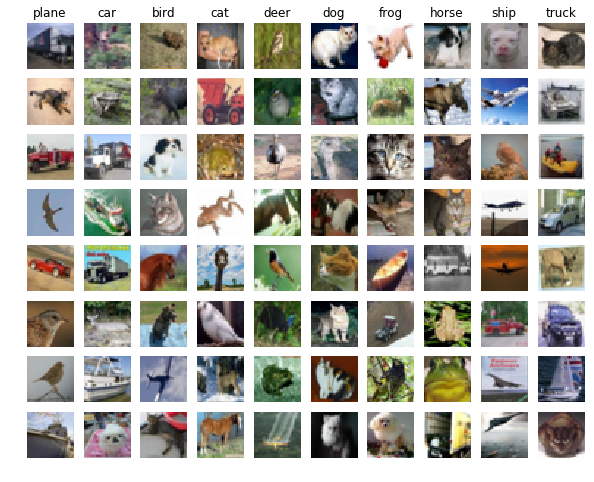

In [25]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense? **Answer**: For instance, the SVM is classifying a bunch of birds as planes and some images with green background as deer. Some of those mistakes make sense when we remeber that the classifier is using color histograms as features, so the color of the images is a crucial factor to the classification result. In the other hand, some mistakes de not make sense at all. This is probably because the features are not enough to distinguish the images correctly.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [26]:
print(X_train_feats.shape)

(49000, 155)


Run 1 / 200: evaluating model.lr:-2.960227.reg:-4.201555.decay.0.936190
	accuracy=0.610000, took=67.357201
	Best model!
Run 2 / 200: evaluating model.lr:-3.450143.reg:-4.757724.decay.0.916223
	accuracy=0.616000, took=105.616811
	Best model!
Run 3 / 200: evaluating model.lr:-3.183332.reg:-4.483587.decay.0.907674
	accuracy=0.624000, took=97.307705
	Best model!
Run 4 / 200: evaluating model.lr:-2.894349.reg:-4.849863.decay.0.948828
	accuracy=0.626000, took=104.174037
	Best model!
Run 5 / 200: evaluating model.lr:-3.177291.reg:-4.314305.decay.0.942744
	accuracy=0.625000, took=98.875153
Run 6 / 200: evaluating model.lr:-2.835085.reg:-4.413455.decay.0.939979
	accuracy=0.621000, took=71.205911
Run 7 / 200: evaluating model.lr:-2.987429.reg:-4.337549.decay.0.924192
	accuracy=0.627000, took=97.301770
	Best model!
Run 8 / 200: evaluating model.lr:-3.307224.reg:-4.232124.decay.0.906841
	accuracy=0.624000, took=132.222939
Run 9 / 200: evaluating model.lr:-3.292068.reg:-4.403387.decay.0.908559
	acc

	accuracy=0.629000, took=132.706199
Run 76 / 200: evaluating model.lr:-2.832127.reg:-4.743383.decay.0.924153
	accuracy=0.615000, took=57.450414
Run 77 / 200: evaluating model.lr:-3.168064.reg:-4.150143.decay.0.933342
	accuracy=0.622000, took=80.877249
Run 78 / 200: evaluating model.lr:-3.172397.reg:-4.561594.decay.0.903563
	accuracy=0.633000, took=126.995691
Run 79 / 200: evaluating model.lr:-3.495193.reg:-4.253550.decay.0.918290
	accuracy=0.627000, took=166.515036
Run 80 / 200: evaluating model.lr:-3.295143.reg:-4.131115.decay.0.909546
	accuracy=0.618000, took=123.176642
Run 81 / 200: evaluating model.lr:-3.451145.reg:-4.744474.decay.0.921786
	accuracy=0.631000, took=160.280843
Run 82 / 200: evaluating model.lr:-2.968740.reg:-4.477598.decay.0.944421
	accuracy=0.610000, took=61.248588
Run 83 / 200: evaluating model.lr:-3.081640.reg:-4.273188.decay.0.918629
	accuracy=0.628000, took=72.058301
Run 84 / 200: evaluating model.lr:-3.345914.reg:-4.864760.decay.0.942117
	accuracy=0.620000, too

	accuracy=0.627000, took=108.113233
Run 152 / 200: evaluating model.lr:-3.456392.reg:-4.187269.decay.0.914301
	accuracy=0.612000, took=80.794187
Run 153 / 200: evaluating model.lr:-3.031803.reg:-4.236082.decay.0.937434
	accuracy=0.615000, took=65.441447
Run 154 / 200: evaluating model.lr:-2.916980.reg:-4.553361.decay.0.920945
	accuracy=0.625000, took=81.253395
Run 155 / 200: evaluating model.lr:-3.213552.reg:-4.072673.decay.0.900953
	accuracy=0.631000, took=124.568382
Run 156 / 200: evaluating model.lr:-3.288725.reg:-4.422477.decay.0.909933
	accuracy=0.620000, took=65.074858
Run 157 / 200: evaluating model.lr:-3.066712.reg:-4.441474.decay.0.932498
	accuracy=0.624000, took=64.860326
Run 158 / 200: evaluating model.lr:-3.158373.reg:-4.143578.decay.0.930088
	accuracy=0.621000, took=80.852020
Run 159 / 200: evaluating model.lr:-2.851605.reg:-4.291308.decay.0.909148
	accuracy=0.617000, took=70.282676
Run 160 / 200: evaluating model.lr:-3.132171.reg:-4.287184.decay.0.936578
	accuracy=0.62200

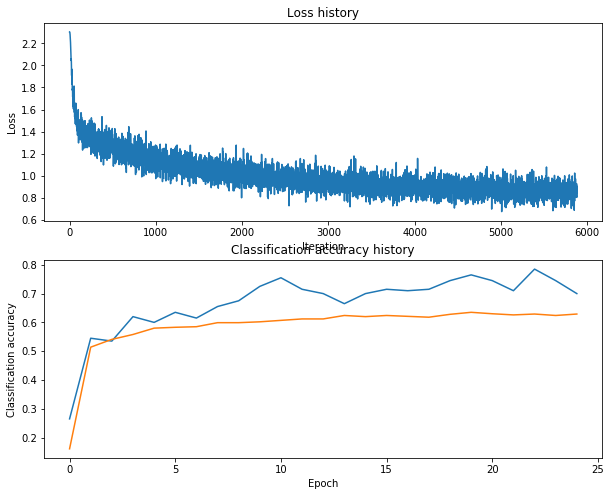

In [71]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
import time

input_size = X_train_feats.shape[1]
num_classes = 10

# Execution parameters
hidden_size = 2000
p_dropout = 0.3
num_iters = 10000
verbose = False

# Search parameters
num_runs = 200

# Limits
intervals = {}
intervals['log_lr'] = [-3.5, -2.8]
intervals['log_rs'] = [-5, -4]
intervals['lr_decay'] = [0.9, 0.95]

def get_modelname(params):
    modelname = 'model.lr:%f.reg:%f.decay.%f' % \
        (params[0], params[1], params[2])
    return modelname


best_acc = -1
best_net = None
best_stats = None
for run in range(num_runs):
    log_lr = np.random.uniform(intervals['log_lr'][0], intervals['log_lr'][1])
    log_rs = np.random.uniform(intervals['log_rs'][0], intervals['log_rs'][1])
    lr_decay = np.random.uniform(intervals['lr_decay'][0], intervals['lr_decay'][1])
    params = [log_lr, log_rs, lr_decay]
    modelname = get_modelname(params) 
    print('Run %d / %d: evaluating %s' % (run + 1, num_runs, modelname))
    
    # Train the network
    lr = np.power(10, log_lr)
    rs = np.power(10, log_rs)
    tic = time.time()
    net = TwoLayerNet(input_size, hidden_size, num_classes, p_dropout=p_dropout)
    stat = net.train(X_train_feats, y_train, X_val_feats, y_val,
                     num_iters=num_iters, batch_size=200,
                     learning_rate=lr, learning_rate_decay=lr_decay,
                     reg=rs, verbose=verbose, optimizer='adam', 
                     early_stop=True, filename='./checkpoints/' + modelname)
    accuracy = max(stat['val_acc_history'])
    print('\taccuracy=%.6f, took=%f' % (accuracy, time.time() - tic))
    
    if accuracy > best_acc:
        best_acc = accuracy
        best_net = net
        best_stats = stat
        best_params = params
        print('\tBest model!')

stats = best_stats
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [72]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.601


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!